Importing required libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL #PIL stands for Python Imaging Library
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


Mounting Google Drive to access dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
p="/content/drive/MyDrive/Agriculture Vision Dataset/All Images"
os.chdir(p)
print('yes')

yes


Defining Batch and Image Size

In [ ]:
batch_size = 32
image_size = (224,224)

Splitting Dataset

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Agriculture Vision Dataset/New Augmented",
    validation_split=0.1,
    subset="training",
    seed=42,
    image_size=(224,224),
    batch_size=32,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Agriculture Vision Dataset/New Augmented",
    validation_split=0.1,
    subset="validation",
    seed=42,
    image_size=(224,224),
    batch_size=32,
)

Found 8000 files belonging to 4 classes.
Using 7200 files for training.
Found 8000 files belonging to 4 classes.
Using 800 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['cloud_shadow', 'standing_water', 'waterway', 'weed_cluster']


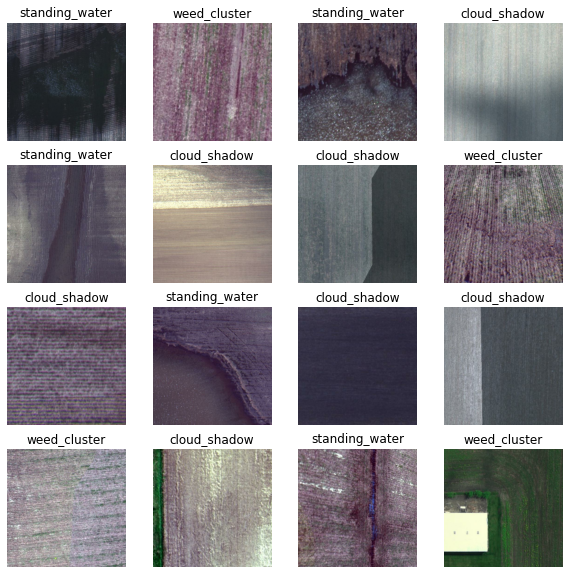

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


DetNet Model

In [ ]:
 '''
version:
TensorFlow==1.7.0
Keras==2.2.4
Python==3.6.5
'''
from keras.models import Model
from keras.layers import Input, Dense, Flatten
from keras.layers import Conv2D, Add, ZeroPadding2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ReLU
from keras.utils import plot_model

# DetNet59 Model Structure
# _______________________________________________________________________________
# Stage   |output size| kernel size | num_filters | num_blocks | stride | dilate
# _______________________________________________________________________________
# Stage 1 |  112x112  |     7x7     |     64      |     ---    |   2   |    1
# -------------------------------------------------------------------------------
#         |           |     3x3     |           max pool       |   2   | 
#         |           |     1x1     |     64       |           |       |
# Stage 2 |   56x56   |     3x3     |     64       |     3     |   1   |    1
#         |           |     1x2     |     256      |           |       |
# ------------------------------------------------------------------------------- 
#         |           |     1x1     |     128      |           |       |
# Stage 3 |   28x28   |     3x3     |     128      |     4     |   2   |    1
#         |           |     1x2     |     512      |           |       |
# -------------------------------------------------------------------------------
#         |           |     1x1     |     256      |           |       |
# Stage 4 |   14x14   |     3x3     |     256      |     6     |   2   |    1
#         |           |     1x2     |     1024     |           |       |
# -------------------------------------------------------------------------------
#         |           |     1x1     |     256      |           |       |
# Stage 5 |   14x14   |     3x3     |     256      |     3     |   1   |    2
#         |           |     1x2     |     256      |           |       |
# -------------------------------------------------------------------------------
#         |           |     1x1     |     256      |           |       |
# Stage 6 |   14x14   |     3x3     |     256      |     3     |   1   |    2
#         |           |     1x2     |     256      |           |       |
# -------------------------------------------------------------------------------
#         |    1x1    |    14x14    |        ave pool, 1000-d fc, softmax 
# -------------------------------------------------------------------------------

def res_block(x, filters_list, strides=1, use_bias=True, name=None):
    '''
    y = f3(f2(f1(x))) + x
    # Conv2D default arguments:
        strides=1
        padding='valid'
        data_format='channels_last'
        dilation_rate=1
        activation=None
        use_bias=True
    '''
    out = Conv2D(filters=filters_list[0], kernel_size=1, strides=1, use_bias=False, name='%s_1'%(name))(x)
    out = BatchNormalization(name='%s_1_bn'%(name))(out)
    out = ReLU(name='%s_1_relu'%(name))(out)

    out = Conv2D(filters=filters_list[1], kernel_size=3, strides=1, padding='same', use_bias=False, name='%s_2'%(name))(out)
    out = BatchNormalization(name='%s_2_bn'%(name))(out)
    out = ReLU(name='%s_2_relu'%(name))(out)

    out = Conv2D(filters=filters_list[2], kernel_size=1, strides=1, use_bias=False, name='%s_3'%(name))(out)
    out = BatchNormalization(name='%s_3_bn'%(name))(out)

    out = Add(name='%s_add'%(name))([x, out])
    out = ReLU(name='%s_relu'%(name))(out)    
    return out

def res_block_proj(x, filters_list, strides=2, use_bias=True, name=None):
    '''
    y = f3(f2(f1(x))) + proj(x)
    '''
    out = Conv2D(filters=filters_list[0], kernel_size=1, strides=strides, use_bias=False, name='%s_1'%(name))(x)
    out = BatchNormalization(name='%s_1_bn'%(name))(out)
    out = ReLU(name='%s_1_relu'%(name))(out)

    out = Conv2D(filters=filters_list[1], kernel_size=3, strides=1, padding='same', use_bias=False, name='%s_2'%(name))(out)
    out = BatchNormalization(name='%s_2_bn'%(name))(out)
    out = ReLU(name='%s_2_relu'%(name))(out)

    out = Conv2D(filters=filters_list[2], kernel_size=1, strides=1, use_bias=False, name='%s_3'%(name))(out)
    out = BatchNormalization(name='%s_3_bn'%(name))(out)

    x = Conv2D(filters=filters_list[2], kernel_size=1, strides=strides, use_bias=False, name='%s_proj'%(name))(x)
    x = BatchNormalization(name='%s_proj_bn'%(name))(x)

    out = Add(name='%s_add'%(name))([x, out])
    out = ReLU(name='%s_relu'%(name))(out)    
    return out

def dilated_res_block(x, filters_list, strides=1, use_bias=True, name=None):
    '''
    y = f3(f2(f1(x))) + x
    '''
    out = Conv2D(filters=filters_list[0], kernel_size=1, strides=1, use_bias=False, name='%s_1'%(name))(x)
    out = BatchNormalization(name='%s_1_bn'%(name))(out)
    out = ReLU(name='%s_1_relu'%(name))(out)

    out = Conv2D(filters=filters_list[1], kernel_size=3, strides=1, padding='same', dilation_rate=2, use_bias=False, name='%s_2'%(name))(out)
    out = BatchNormalization(name='%s_2_bn'%(name))(out)
    out = ReLU(name='%s_2_relu'%(name))(out)

    out = Conv2D(filters=filters_list[2], kernel_size=1, strides=1, use_bias=False, name='%s_3'%(name))(out)
    out = BatchNormalization(name='%s_3_bn'%(name))(out)

    out = Add(name='%s_add'%(name))([x, out])
    out = ReLU(name='%s_relu'%(name))(out)    
    return out

def dilated_res_block_proj(x, filters_list, strides=1, use_bias=True, name=None):
    '''
    y = f3(f2(f1(x))) + proj(x)
    '''
    out = Conv2D(filters=filters_list[0], kernel_size=1, strides=1, use_bias=False, name='%s_1'%(name))(x)
    out = BatchNormalization(name='%s_1_bn'%(name))(out)
    out = ReLU(name='%s_1_relu'%(name))(out)

    out = Conv2D(filters=filters_list[1], kernel_size=3, strides=1, padding='same', dilation_rate=2, use_bias=False, name='%s_2'%(name))(out)
    out = BatchNormalization(name='%s_2_bn'%(name))(out)
    out = ReLU(name='%s_2_relu'%(name))(out)

    out = Conv2D(filters=filters_list[2], kernel_size=1, strides=1, use_bias=False, name='%s_3'%(name))(out)
    out = BatchNormalization(name='%s_3_bn'%(name))(out)

    x = Conv2D(filters=filters_list[2], kernel_size=1, strides=1, use_bias=False, name='%s_proj'%(name))(x)
    x = BatchNormalization(name='%s_proj_bn'%(name))(x)

    out = Add(name='%s_add'%(name))([x, out])
    out = ReLU(name='%s_relu'%(name))(out)    
    return out

def resnet_body(x, filters_list, num_blocks, strides=2, name=None):
    out = res_block_proj(x=x, filters_list=filters_list, strides=strides, name='%s_1'%(name))
    for i in range(1, num_blocks):
        out = res_block(x=out, filters_list=filters_list, name='%s_%s'%(name, str(i+1)))
    return out

def detnet_body(x, filters_list, num_blocks, strides=1, name=None):
    out = dilated_res_block_proj(x=x, filters_list=filters_list, name='%s_1'%(name))
    for i in range(1, num_blocks):
        out = dilated_res_block(x=out, filters_list=filters_list, name='%s_%s'%(name, str(i+1)))
    return out


def detnet_59(inputs, filters_list, blocks_list, num_classes):
    # stage 1
    inputs_pad = ZeroPadding2D(padding=3, name='inputs_pad')(inputs)
    conv1 = Conv2D(filters=filters_list[0][0], kernel_size=7, strides=2, use_bias=False, name='conv1')(inputs_pad)
    conv1 = BatchNormalization(name='conv1_bn')(conv1)
    conv1 = ReLU(name='conv1_relu')(conv1)

    # stage 2
    conv1_pad = ZeroPadding2D(padding=1, name='conv1_pad')(conv1)
    conv1_pool = MaxPooling2D(pool_size=3, strides=2, name='conv1_maxpool')(conv1_pad)
    conv2_x = resnet_body(x=conv1_pool, filters_list=filters_list[1], num_blocks=blocks_list[1], strides=1, name='res2')

    # stage 3
    conv3_x = resnet_body(x=conv2_x, filters_list=filters_list[2], num_blocks=blocks_list[2], strides=2, name='res3')

    # stage 4
    conv4_x = resnet_body(x=conv3_x, filters_list=filters_list[3], num_blocks=blocks_list[3], strides=2, name='res4')

    # stage 5
    conv5_x = detnet_body(x=conv4_x, filters_list=filters_list[4], num_blocks=blocks_list[4], strides=1, name='dires5')

    # stage 6
    conv6_x = detnet_body(x=conv5_x, filters_list=filters_list[5], num_blocks=blocks_list[5], strides=1, name='dires6')

    out = AveragePooling2D(pool_size=14, strides=1, name='final_avepool')(conv6_x)
    out = Flatten(name='flatten')(out)
    outputs = Dense(units=num_classes, activation="softmax", kernel_initializer='he_normal', name='dense')(out)
    model = Model(inputs=inputs, outputs=outputs) 
    return model

if __name__=='__main__':
    # create a keras model detnet_59
    inputs = Input(shape=(224,224,3), name='inputs')
    filters_list=[[64],
                  [64,64,256],                  
                  [128,128,512],
                  [256,256,1024],
                  [256,256,256],
                  [256,256,256]]
    blocks_list=[1,3,4,6,3,3]
    num_classes = 4
    model = detnet_59(inputs, filters_list, blocks_list, num_classes)

    # check the model
    model.summary()
    model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
    print('Model Compiled')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
inputs_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           inputs[0][0]                     
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9408        inputs_pad[0][0]                 
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
______________________________________________________________________________________________

Training Model (Adam's optimizer used)

In [ ]:
model = detnet_59(inputs, filters_list, blocks_list, num_classes)
model.compile(optimizer='Adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
detnet = model.fit(train_ds, validation_data = val_ds, steps_per_epoch = 10, epochs = 20)

Epoch 1/20
10/10 [==============================] - 14s 962ms/step - loss: 1.9713 - accuracy: 0.4026 - val_loss: 1183.8301 - val_accuracy: 0.2450
Epoch 2/20
10/10 [==============================] - 8s 870ms/step - loss: 1.4641 - accuracy: 0.3689 - val_loss: 8490.1680 - val_accuracy: 0.2450
Epoch 3/20
10/10 [==============================] - 8s 890ms/step - loss: 1.4090 - accuracy: 0.4295 - val_loss: 10739.4590 - val_accuracy: 0.2313
Epoch 4/20
10/10 [==============================] - 8s 891ms/step - loss: 1.1257 - accuracy: 0.5485 - val_loss: 2828.1917 - val_accuracy: 0.2288
Epoch 5/20
10/10 [==============================] - 8s 877ms/step - loss: 1.1873 - accuracy: 0.5285 - val_loss: 925.9371 - val_accuracy: 0.2288
Epoch 6/20
10/10 [==============================] - 8s 886ms/step - loss: 1.1574 - accuracy: 0.5231 - val_loss: 341.3855 - val_accuracy: 0.2288
Epoch 7/20
10/10 [==============================] - 8s 874ms/step - loss: 1.0295 - accuracy: 0.6131 - val_loss: 258.6312 - val_acc

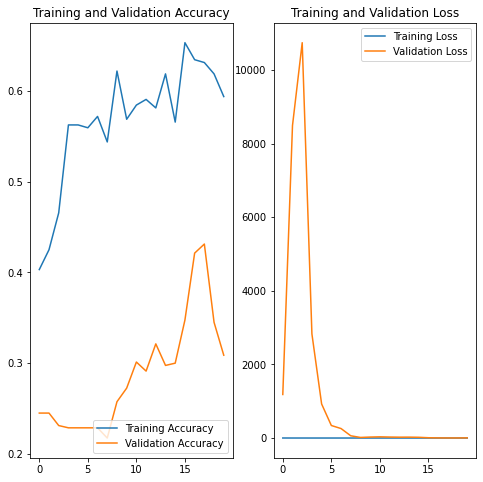

In [ ]:
acc = detnet.history['accuracy']
val_acc = detnet.history['val_accuracy']

loss = detnet.history['loss']
val_loss = detnet.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Compiling the model using SGD optimizer

In [ ]:
model.compile(optimizer='SGD', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
detnet = model.fit(train_ds, validation_data = val_ds, steps_per_epoch = 10, epochs = 20)

Epoch 1/20
10/10 [==============================] - 13s 967ms/step - loss: 0.8660 - accuracy: 0.6963 - val_loss: 3.2343 - val_accuracy: 0.2988
Epoch 2/20
10/10 [==============================] - 8s 873ms/step - loss: 0.8081 - accuracy: 0.6720 - val_loss: 2.1776 - val_accuracy: 0.3675
Epoch 3/20
10/10 [==============================] - 8s 891ms/step - loss: 0.7413 - accuracy: 0.7014 - val_loss: 2.6158 - val_accuracy: 0.3200
Epoch 4/20
10/10 [==============================] - 8s 888ms/step - loss: 0.8988 - accuracy: 0.6703 - val_loss: 1.9588 - val_accuracy: 0.3600
Epoch 5/20
10/10 [==============================] - 8s 880ms/step - loss: 0.7750 - accuracy: 0.7258 - val_loss: 2.3285 - val_accuracy: 0.2988
Epoch 6/20
10/10 [==============================] - 8s 875ms/step - loss: 0.7537 - accuracy: 0.7327 - val_loss: 1.3104 - val_accuracy: 0.4950
Epoch 7/20
10/10 [==============================] - 8s 873ms/step - loss: 0.6888 - accuracy: 0.7611 - val_loss: 1.3574 - val_accuracy: 0.4663
Epoch

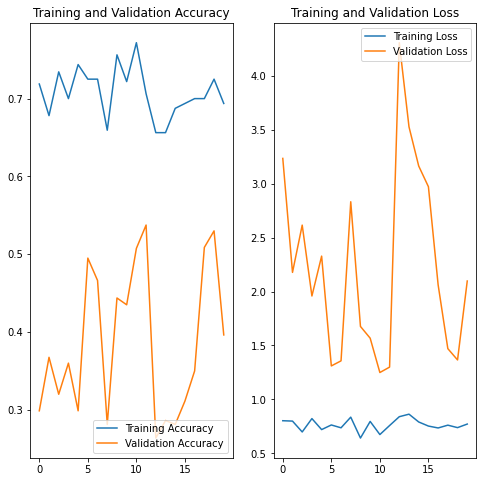

In [ ]:
acc = detnet.history['accuracy']
val_acc = detnet.history['val_accuracy']

loss = detnet.history['loss']
val_loss = detnet.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()